In [1]:
import uproot
import uproot_methods

import awkward

# Histogram section
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

file = '*.root'

In [2]:
def particle_selection(hlt, save_name, year):
    
    # Histogram definition
    
    # Dimuon
    hist_dimuon = bh.Histogram(bh.axis.Regular(50, 10, 50, metadata=r"$p_{T,\mu^+\mu^-}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{\mu^+\mu^-}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{\mu^+\mu^-}$"),)
    
    # Quarkonia
    hist_quarkonia_mass_trigger = bh.Histogram(bh.axis.Regular(100, 2, 4, metadata=r"$m_{\mu^+\mu^-}$ [GeV]"))
    
    # D0
    hist_d0_mass_trigger = bh.Histogram(bh.axis.Regular(100, 0.6, 3.2, metadata=r"$m_{D^0}$ [GeV]"))
    hist_d0 = bh.Histogram(bh.axis.Regular(300, 0, 50, metadata=r"$p_{T,D^0}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{D^0}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{D^0}$"),)
    
    # Muon vertex
    hist_dimuon_vertex = bh.Histogram(bh.axis.Regular(100, -1, 1., metadata=r"$\mu^+\mu^-_{v_x}$ [GeV]"),
                                  bh.axis.Regular(100, -1., 1., metadata=r"$\mu^+\mu^-_{v_y}$ [GeV]"),
                                  bh.axis.Regular(100, -15, 15., metadata=r"$\mu^+\mu^-_{v_z}$ [GeV]"),)
    
    # D0 tracks pT
    hist_tracks_pt = bh.Histogram(bh.axis.Regular(300, 0, 40, metadata=r"$p_{T,track1 D0}$ [GeV]"),
                                  bh.axis.Regular(300, 0, 40, metadata=r"$p_{T,track2 D0}$ [GeV]"),)
    
    
    # D0 vertex
    hist_d0_vertex = bh.Histogram(bh.axis.Regular(100, -1, 1., metadata=r"$D^0_{v_x}$ [GeV]"),
                                  bh.axis.Regular(100, -1, 1., metadata=r"$D^0_{v_y}$ [GeV]"),
                                  bh.axis.Regular(100, -15, 15., metadata=r"$D^0_{v_z}$ [GeV]"),)
    
    trigger = np.array([])
    # Muon selection
    branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_isGlobal', 'Muon_softId', 'Muon_vtxIdx' , 'Muon_x', 'Muon_y', 'Muon_z'
                    ,'nD0', 'D0_pt', 'D0_eta', 'D0_phi', 'D0_mass12', 'D0_vtxIdx', 'D0_x', 'D0_y', 'D0_z', 'D0t1_pt', 'D0t2_pt', hlt]
    for chunk in uproot.iterate(file, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
        Muon = JaggedCandidateArray.candidatesfromcounts(chunk['nMuon'],
                                                pt=chunk['Muon_pt'].content,
                                                eta=chunk['Muon_eta'].content,
                                                phi=chunk['Muon_phi'].content,
                                                mass=chunk['Muon_mass'].content,
                                                charge=chunk['Muon_charge'].content,
                                                isGlobal=chunk['Muon_isGlobal'].content,
                                                softId=chunk['Muon_softId'].content,   
                                                vtxIdx=chunk['Muon_vtxIdx'].content,
                                                x=chunk['Muon_x'].content,
                                                y=chunk['Muon_y'].content,
                                                z=chunk['Muon_z'].content,
                                                          
                                               )
        D0 = JaggedCandidateArray.candidatesfromcounts(chunk['nD0'],
                                                    pt=chunk['D0_pt'].content,
                                                    eta=chunk['D0_eta'].content,
                                                    phi=chunk['D0_phi'].content,
                                                    mass=chunk['D0_mass12'].content,
                                                    vtxIdx=chunk['D0_vtxIdx'].content,
                                                    x=chunk['D0_x'].content,
                                                    y=chunk['D0_y'].content,
                                                    z=chunk['D0_z'].content,
                                                    pt_tk1=chunk['D0t1_pt'].content,
                                                    pt_tk2=chunk['D0t2_pt'].content,)
    
        trigger = np.where(chunk[hlt] > 0, True, False)        
        
        Muon = Muon[trigger]
        D0 = D0[trigger]

        # Basic muon cuts.

        # Soft id cut
        soft_id = (Muon.softId > 0)
        Muon = Muon[soft_id]

        # Global cut
        global_muon = (Muon.isGlobal > 0)
        Muon = Muon[global_muon]

        # pT cuts
        pt_cut = (Muon.pt > 3)
        Muon = Muon[pt_cut]

        # eta_cut
        eta_cut = (np.absolute(Muon.eta) <= 2.4)
        Muon = Muon[eta_cut]

        # Dimuons cuts

        Dimuon_ = (Muon.counts > 1)
        Muon = Muon[Dimuon_]

        D0 = D0[Dimuon_]

        Dimuon = Muon.distincts()

        # Charge and vertex cuts

        opposite_charge = (Dimuon.i0['charge'] * Dimuon.i1['charge'] < 0)
        Dimuon = Dimuon[opposite_charge]

        same_vtx = (Dimuon.i0['vtxIdx'] == Dimuon.i1['vtxIdx']) | (np.absolute(Dimuon.i0['z'] - Dimuon.i1['z']) < 0.2)
        Dimuon = Dimuon[same_vtx]

        # Only events with at least 1 dimuon
        evtcut = (Dimuon.counts > 0)
        Dimuon = Dimuon[evtcut]

        D0 = D0[evtcut]

        # Quarkonia selection
        Dimuon_mass_quarkonia = ((Dimuon.mass > 2.95) & (Dimuon.mass < 3.25))
        quarkonia = Dimuon[Dimuon_mass_quarkonia]
        
        ################## Filling histograms ##################
        
        hist_dimuon.fill(quarkonia.pt.flatten(), quarkonia.eta.flatten(), quarkonia.phi.flatten())
        
        hist_quarkonia_mass_trigger.fill(quarkonia.mass.flatten())
        
        hist_d0_mass_trigger.fill(D0.mass.flatten())
        
        hist_d0.fill(D0.pt.flatten(), D0.eta.flatten(), D0.phi.flatten())
        
        hist_d0_vertex.fill(D0.x.flatten(), D0.y.flatten(), D0.z.flatten())
        
        hist_dimuon_vertex.fill(Muon.x.flatten(), Muon.y.flatten(), Muon.z.flatten())
        
        hist_tracks_pt.fill(D0.pt_tk1.flatten(), D0.pt_tk2.flatten())
        
        
    # Calls plots
    generate_plot_1d(hist_dimuon[:, sum, sum], "dimuon pT plot - " + save_name, year)
    generate_plot_1d(hist_dimuon[sum, :, sum], "dimuon eta plot - " + save_name, year)
    generate_plot_1d(hist_dimuon[sum, sum, :], "dimuon phi plot - " + save_name, year)

    generate_plot_1d(hist_quarkonia_mass_trigger, "jpsi mass plot - " + save_name, year)
    
    generate_plot_1d(hist_tracks_pt[:, sum], "Track 1 D0 - " + save_name, year)
    generate_plot_1d(hist_tracks_pt[sum, :], "Track 2 D0 - " + save_name, year)

    generate_plot_1d(hist_d0_mass_trigger, "D0 mass plot - " + save_name, year)
    generate_plot_1d(hist_d0[:, sum, sum], "D0 pT plot - " + save_name, year)
    generate_plot_1d(hist_d0[sum, :, sum], "D0 eta plot - " + save_name, year)
    generate_plot_1d(hist_d0[sum, sum, :], "D0 phi plot - " + save_name, year)
        
    return hist_d0_vertex, hist_dimuon_vertex
    

In [3]:
def particle_selection_dimu(hlt, save_name, year):
    
    # Histogram definition
    
    # Dimuon
    hist_dimuon = bh.Histogram(bh.axis.Regular(50, 10, 50, metadata=r"$p_{T,\mu^+\mu^-}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{\mu^+\mu^-}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{\mu^+\mu^-}$"),)
    
    # Quarkonia
    hist_quarkonia_mass_trigger = bh.Histogram(bh.axis.Regular(100, 2, 4, metadata=r"$m_{\mu^+\mu^-}$ [GeV]"))
    
    # D0
    hist_d0_mass_trigger = bh.Histogram(bh.axis.Regular(100, 0.6, 3.2, metadata=r"$m_{D^0}$ [GeV]"))
    hist_d0 = bh.Histogram(bh.axis.Regular(300, 0, 50, metadata=r"$p_{T,D^0}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{D^0}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{D^0}$"),)
    
    # Dimuon vertex
    hist_dimuon_vertex = bh.Histogram(bh.axis.Regular(100, -0.5, 0.5, metadata=r"$\mu^+\mu^-_{v_x}$ [GeV]"),
                                  bh.axis.Regular(100, -0.5, 0.5, metadata=r"$\mu^+\mu^-_{v_y}$ [GeV]"),
                                  bh.axis.Regular(100, -15., 15., metadata=r"$\mu^+\mu^-_{v_z}$ [GeV]"),)
    
    # D0 tracks pT
    hist_tracks_pt = bh.Histogram(bh.axis.Regular(300, 0, 40, metadata=r"$p_{T,track1 D0}$ [GeV]"),
                                  bh.axis.Regular(300, 0, 40, metadata=r"$p_{T,track2 D0}$ [GeV]"),)
    
    
    # D0 vertex
    hist_d0_vertex = bh.Histogram(bh.axis.Regular(100, -0.5, 0.5, metadata=r"$D^0_{v_x}$ [GeV]"),
                                  bh.axis.Regular(100, -0.5, 0.5, metadata=r"$D^0_{v_y}$ [GeV]"),
                                  bh.axis.Regular(100, -15., 15., metadata=r"$D^0_{v_z}$ [GeV]"),)
    
    trigger = np.array([])
    # Branches of interest
    branches = ['nDimu', 'Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx' , 'Dimu_x', 'Dimu_y', 'Dimu_z'
                    ,'nD0', 'D0_pt', 'D0_eta', 'D0_phi', 'D0_mass12', 'D0_vtxIdx', 'D0_x', 'D0_y', 'D0_z', 'D0t1_pt', 'D0t2_pt', hlt]
    for chunk in uproot.iterate(file, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
        Dimu = JaggedCandidateArray.candidatesfromcounts(chunk['nDimu'],
                                                pt=chunk['Dimu_pt'].content,
                                                eta=chunk['Dimu_eta'].content,
                                                phi=chunk['Dimu_phi'].content,
                                                mass=chunk['Dimu_mass'].content,
                                                charge=chunk['Dimu_charge'].content,   
                                                vtxIdx=chunk['Dimu_vtxIdx'].content,
                                                x=chunk['Dimu_x'].content,
                                                y=chunk['Dimu_y'].content,
                                                z=chunk['Dimu_z'].content,
                                                          
                                               )
        D0 = JaggedCandidateArray.candidatesfromcounts(chunk['nD0'],
                                                    pt=chunk['D0_pt'].content,
                                                    eta=chunk['D0_eta'].content,
                                                    phi=chunk['D0_phi'].content,
                                                    mass=chunk['D0_mass12'].content,
                                                    vtxIdx=chunk['D0_vtxIdx'].content,
                                                    x=chunk['D0_x'].content,
                                                    y=chunk['D0_y'].content,
                                                    z=chunk['D0_z'].content,
                                                    pt_tk1=chunk['D0t1_pt'].content,
                                                    pt_tk2=chunk['D0t2_pt'].content,)
    
        trigger = np.where(chunk[hlt] > 0, True, False)        
        
        Dimu = Dimu[trigger]
        D0 = D0[trigger]

        # Basic Dimu cuts.

        pt_cut = (Dimu.pt > 3)
        Dimu = Dimu[pt_cut]

        # eta_cut
        eta_cut = (np.absolute(Dimu.eta) <= 2.4)
        Dimu = Dimu[eta_cut]

        # Quarkonia selection
        Dimuon_mass_quarkonia = ((Dimu.mass > 2.95) & (Dimu.mass < 3.25))
        quarkonia = Dimu[Dimuon_mass_quarkonia]
        
        ################## Filling histograms ##################
        
        hist_dimuon.fill(quarkonia.pt.flatten(), quarkonia.eta.flatten(), quarkonia.phi.flatten())
        
        hist_quarkonia_mass_trigger.fill(quarkonia.mass.flatten())
        
        hist_d0_mass_trigger.fill(D0.mass.flatten())
        
        hist_d0.fill(D0.pt.flatten(), D0.eta.flatten(), D0.phi.flatten())
        
        hist_d0_vertex.fill(D0.x.flatten(), D0.y.flatten(), D0.z.flatten())
        
        hist_dimuon_vertex.fill(Dimu.x.flatten(), Dimu.y.flatten(), Dimu.z.flatten())
        
        hist_tracks_pt.fill(D0.pt_tk1.flatten(), D0.pt_tk2.flatten())
        
        
    # Calls plots
    generate_plot_1d(hist_dimuon[:, sum, sum], "dimuon pT plot - " + save_name, year)
    generate_plot_1d(hist_dimuon[sum, :, sum], "dimuon eta plot - " + save_name, year)
    generate_plot_1d(hist_dimuon[sum, sum, :], "dimuon phi plot - " + save_name, year)

    generate_plot_1d(hist_quarkonia_mass_trigger, "jpsi mass plot - " + save_name, year)
    
    generate_plot_1d(hist_tracks_pt[:, sum], "Track 1 D0 - " + save_name, year)
    generate_plot_1d(hist_tracks_pt[sum, :], "Track 2 D0 - " + save_name, year)

    generate_plot_1d(hist_d0_mass_trigger, "D0 mass plot - " + save_name, year)
    generate_plot_1d(hist_d0[:, sum, sum], "D0 pT plot - " + save_name, year)
    generate_plot_1d(hist_d0[sum, :, sum], "D0 eta plot - " + save_name, year)
    generate_plot_1d(hist_d0[sum, sum, :], "D0 phi plot - " + save_name, year)
        
    return hist_d0_vertex, hist_dimuon_vertex
    

In [4]:
def generate_plot_1d(hist, save_name, year): 
    
    
    if "p_{T," in hist.axes[0].metadata:
        plt.xscale('log')
        
    
    ax = plt.gca()
    
    ax.set_xlabel(hist.axes[0].metadata, loc='right')
    ax.set_ylabel("Counts", loc='top')

    mean = (hist.view() * hist.axes[0].centers).sum()/hist.sum()
    std = np.sqrt((hist.view()*((hist.axes[0].centers - mean)**2)).sum()/hist.sum())

    hep.histplot(hist, ax=ax)

    annotation = f"Total {hist.sum()}" \
               + "\n" + f"Mean: {round(mean,2)}" \
               + "\n" + f"Std: {round(std,2)}"
    ax.annotate(annotation, xy=(0.85, 0.85), xycoords='axes fraction', fontsize = "small",
               ha='center', annotation_clip=False, bbox=dict(boxstyle='round', fc='None'))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

    fig = ax.get_figure()

    fig.savefig("hlt_choice_" + year + "/" + save_name)

    ax.clear()
    
    

In [5]:
def charmonium_trigger(year):
    import os, sys, subprocess
    
    os.system("rm -rf hlt_choice_" + year)
    os.system("mkdir -p hlt_choice_" + year)
    
    
    # 2017 HLT path
    if year == "2017":
        #particle_selection("HLT_Dimuon0_Jpsi_L1_4R_0er1p5R", "HLT_Dimuon0_Jpsi_L1_4R_0er1p5R", year)
        #particle_selection("HLT_Dimuon0_Jpsi_L1_NoOS", "HLT_Dimuon0_Jpsi_L1_NoOS", year)   
        #particle_selection("HLT_Dimuon0_Jpsi", "HLT_Dimuon0_Jpsi", year)
        #particle_selection("HLT_Dimuon0_LowMass_L1_0er1p5", "HLT_Dimuon0_LowMass_L1_0er1p5", year)
        #particle_selection("HLT_Dimuon0_LowMass_L1_4", "HLT_Dimuon0_LowMass_L1_4", year)
        #particle_selection("HLT_Dimuon0_LowMass", "HLT_Dimuon0_LowMass", year)
        #particle_selection("HLT_Dimuon20_Jpsi_Barrel_Seagulls", "HLT_Dimuon20_Jpsi_Barrel_Seagulls", year)
        #particle_selection("HLT_Dimuon25_Jpsi_noCorrL1", "HLT_Dimuon25_Jpsi_noCorrL1", year)
        #particle_selection("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", year)
        particle_selection_dimu("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", year)
        #particle_selection("HLT_DoubleMu4_3_Jpsi", "HLT_DoubleMu4_3_Jpsi", year)
        #particle_selection("HLT_DoubleMu4_Jpsi_Displaced", "HLT_DoubleMu4_Jpsi_Displaced", year)
    
    

In [6]:
#charmonium_trigger("2017")

In [7]:
def generate_vertexplot_1d(hist_dimu, hist_d0, save_name, year): 
    
    from matplotlib.patches import Rectangle
    
    cmap = plt.get_cmap('jet')
    low = cmap(0.1)
    medium =cmap(0.7)
    
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low, medium]]
    
    if hist_d0_vertex.axes[0].metadata.find('$D^0') == 0:
        str_open_charm = r"$D^0-vertex$"
        
    labels = [r"$\mu^+\mu^--vertex$", r"$D^0-vertex$"]
    plt.legend(handles, labels)
    
    # Dimuons plots
    ax = plt.gca()

    ax.set_xlabel(hist_dimu.axes[0].metadata, loc='right')

    ax.set_ylabel("Counts", loc='top')

    mean = (hist_dimu.view() * hist_dimu.axes[0].centers).sum()/hist_dimu.sum()
    std = np.sqrt((hist_dimu.view()*((hist_dimu.axes[0].centers - mean)**2)).sum()/hist_dimu.sum())

    hep.histplot(hist_dimu, ax=ax, color=low)

    annotation = f"Total {hist_dimu.sum()}" \
               + "\n" + f"Mean: {round(mean,2)}" \
               + "\n" + f"Std: {round(std,2)}"
    ax.annotate(annotation, xy=(0.8, 0.7), xycoords='axes fraction', fontsize = "small",
               ha='center', annotation_clip=False, bbox=dict(boxstyle='round', fc='None', color=low))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

    fig = ax.get_figure()

    # D0 plots
    bx = plt.gca()
    
    a = hist_d0.axes[0].metadata
    b = a.replace(hist_d0.axes[0].metadata, hist_d0.axes[0].metadata[8])

    bx.set_xlabel(b + '[cm]', loc='right')

    bx.set_ylabel("Counts", loc='top')

    mean = (hist_d0.view() * hist_d0.axes[0].centers).sum()/hist_d0.sum()
    std = np.sqrt((hist_d0.view()*((hist_d0.axes[0].centers - mean)**2)).sum()/hist_d0.sum())

    hep.histplot(hist_d0, ax=bx, color=medium)

    annotation = f"Total {hist_d0.sum()}" \
               + "\n" + f"Mean: {round(mean,2)}" \
               + "\n" + f"Std: {round(std,2)}"
    bx.annotate(annotation, xy=(0.8, 0.52), xycoords='axes fraction', fontsize = "small",
               ha='center', annotation_clip=False, bbox=dict(boxstyle='round', fc='None', color=medium))
    bx.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    fig.savefig("vertex_comparison_" + year + "/" + save_name)
    
    ax.clear()
    bx.clear()
    

In [8]:
def vertex_comparison(year):
  
    import os, sys, subprocess
    
    os.system("rm -rf vertex_comparison_" + year)
    os.system("mkdir -p vertex_comparison_" + year)

    hist_d0_vertex, hist_dimuon_vertex = particle_selection_dimu("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", "2017")

    # x distributions
    generate_vertexplot_1d(hist_dimuon_vertex[:, sum, sum], hist_d0_vertex[:, sum, sum], "HLT_Dimuon25_Jpsi_vertex_x", "2017" )
    # y distributions
    generate_vertexplot_1d(hist_dimuon_vertex[sum, :, sum], hist_d0_vertex[sum, :, sum], "HLT_Dimuon25_Jpsi_vertex_y", "2017" )
    # z distributions
    generate_vertexplot_1d(hist_dimuon_vertex[sum, sum, :], hist_d0_vertex[sum, sum, :], "HLT_Dimuon25_Jpsi_vertex_z", "2017" )

In [ ]:
hist_d0_vertex, hist_dimuon_vertex = particle_selection_dimu("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", "2017")

In [29]:
if hist_d0_vertex.axes[0].metadata.find('$D^0') == 0:
    str_open_charm = r"$D^0-vertex$"
        
labels = [r"$\mu^+\mu^--vertex$", str_open_charm]

In [30]:
labels

['$\\mu^+\\mu^--vertex$', '$D^0-vertex$']

In [11]:
np.where(hist_d0_vertex.axes[0].metadata.str.find('RE+4') != 0, True, False))

'$D^0_{v_x}$ [GeV]'

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


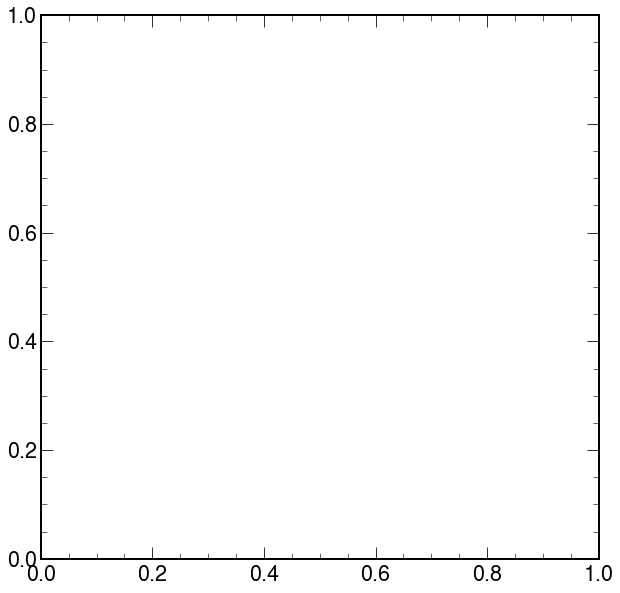

In [9]:
vertex_comparison("2017")

ValueError: too many values to unpack (expected 3)

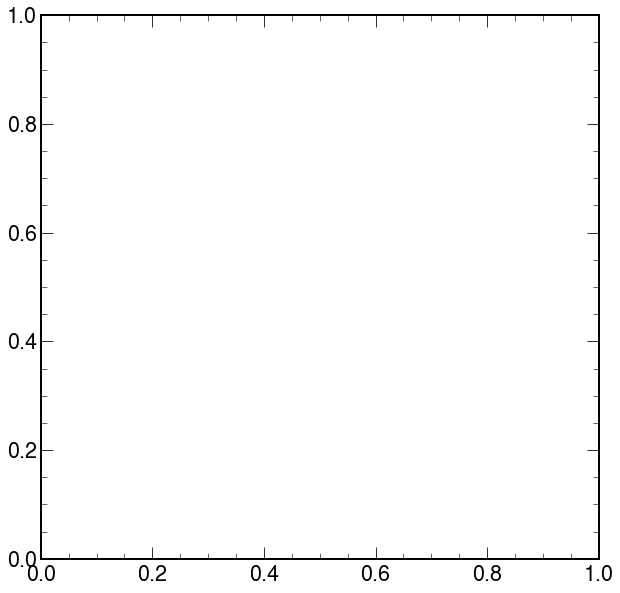

In [155]:
# 2d plots. not working =/
import boost_histogram as bh
import matplotlib.pyplot as plt
import numpy as np

# Create 2d-histogram with two axes with 20 equidistant bins from -3 to 3
hist_d0_vertex, hist_dimuon_vertex = particle_selection("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", "2017")

w, x, y = hist_d0_vertex.to_numpy()

# Draw the count matrix

fig, ax = plt.subplots()
ax.pcolormesh(x, y, w.T)
ax.set_xlabel(hist_d0_vertex.axes[0].metadata)
ax.set_ylabel(hist_d0_vertex.axes[1].metadata)
#ax.set_zlabel(hist_d0_vertex.axes[2].metadata)
ax.set_aspect("equal")
#plt.savefig("simple_2d.png")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()


hist_d0_vertex, hist_dimuon_vertex = particle_selection("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", "2017")

# D0 vertex plot

w, x, y, z = hist_d0_vertex.to_numpy()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=20, c=None, depthshade=True)

ax.set_xlabel('x vertex')
ax.set_ylabel('y vertex')
ax.set_zlabel('z vertex')

# Dimuon vertex plot

#mw, mx, my, mz = hist_dimuon_vertex.to_numpy()



bx = fig.add_subplot(111, projection='3d')

bx.scatter(mx, my, mz, s=20, c=None, depthshade=True)

bx.set_xlabel('x vertex')
bx.set_ylabel('y vertex')
bx.set_zlabel('z vertex')


plt.show()

In [26]:
x = hist_d0_vertex[:, sum, sum].to_numpy()

In [29]:
x[1]

array([-3.  , -2.94, -2.88, -2.82, -2.76, -2.7 , -2.64, -2.58, -2.52,
       -2.46, -2.4 , -2.34, -2.28, -2.22, -2.16, -2.1 , -2.04, -1.98,
       -1.92, -1.86, -1.8 , -1.74, -1.68, -1.62, -1.56, -1.5 , -1.44,
       -1.38, -1.32, -1.26, -1.2 , -1.14, -1.08, -1.02, -0.96, -0.9 ,
       -0.84, -0.78, -0.72, -0.66, -0.6 , -0.54, -0.48, -0.42, -0.36,
       -0.3 , -0.24, -0.18, -0.12, -0.06,  0.  ,  0.06,  0.12,  0.18,
        0.24,  0.3 ,  0.36,  0.42,  0.48,  0.54,  0.6 ,  0.66,  0.72,
        0.78,  0.84,  0.9 ,  0.96,  1.02,  1.08,  1.14,  1.2 ,  1.26,
        1.32,  1.38,  1.44,  1.5 ,  1.56,  1.62,  1.68,  1.74,  1.8 ,
        1.86,  1.92,  1.98,  2.04,  2.1 ,  2.16,  2.22,  2.28,  2.34,
        2.4 ,  2.46,  2.52,  2.58,  2.64,  2.7 ,  2.76,  2.82,  2.88,
        2.94,  3.  ])

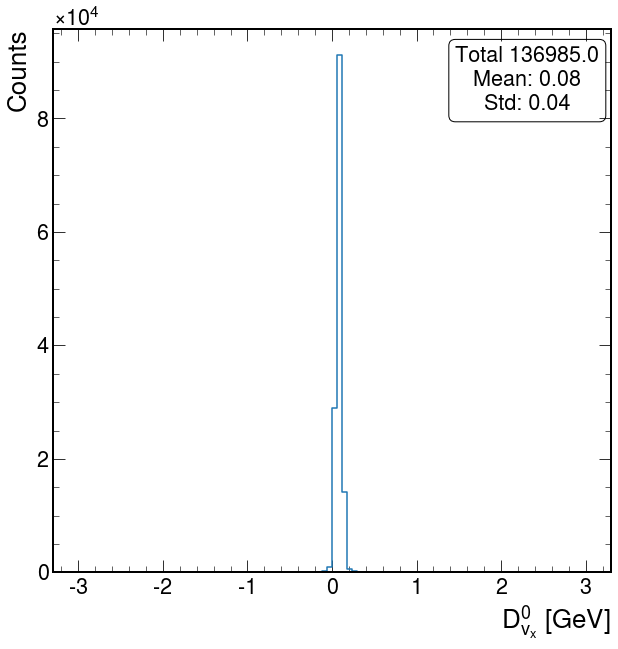

In [34]:
ax = plt.gca()
    
ax.set_xlabel(hist_d0_vertex[:, sum, sum].axes[0].metadata, loc='right')
ax.set_ylabel("Counts", loc='top')

mean = (hist_d0_vertex[:, sum, sum].view() * hist_d0_vertex[:, sum, sum].axes[0].centers).sum()/hist_d0_vertex[:, sum, sum].sum()
std = np.sqrt((hist_d0_vertex[:, sum, sum].view()*((hist_d0_vertex[:, sum, sum].axes[0].centers - mean)**2)).sum()/hist_d0_vertex[:, sum, sum].sum())

hep.histplot(hist_d0_vertex[:, sum, sum], ax=ax)

annotation = f"Total {hist_d0_vertex[:, sum, sum].sum()}" \
           + "\n" + f"Mean: {round(mean,2)}" \
           + "\n" + f"Std: {round(std,2)}"
ax.annotate(annotation, xy=(0.85, 0.85), xycoords='axes fraction', fontsize = "small",
           ha='center', annotation_clip=False, bbox=dict(boxstyle='round', fc='None'))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

fig = ax.get_figure()

#fig.savefig("hlt_choice_" + year + "/" + save_name)



In [ ]:
'''
==============
3D scatterplot
==============

Demonstration of a basic scatterplot in 3D.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)
print (type(xs))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()